<a href="https://colab.research.google.com/github/Angus-Eastell/Intro_to_AI/blob/main/8_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Enable for prettier plots
%matplotlib inline
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual, interactive
from IPython.display import display

# Overfitting, regularisation and cross-validation

**The code in this notebook is non-examinable!! We're doing some slightly weird stuff to get the nice visualisations!!**

To understand overfitting, regularisation and cross-validation, we need to start by defining an interesting set of function approximators.  We're going to use linear functions with an interesting set of basis functions.  Specifically,
\begin{align}
  f(x) = \mathbf{w} \boldsymbol{\psi}(x)
\end{align}
Here, $\boldsymbol{\psi}(x)$ is a vector of fixed, nonlinear basis functions.
We use the so-called Chebyshev polynomials (we're only using these because they give a nice basis, the Chebyshev polynomials themselves are non-examinable).
\begin{align}
  \psi_0(x) &= 1\\
  \psi_1(x) &= x\\
  \psi_2(x) &= 2x^2 - 1\\
  ...
\end{align}
These functions look like:

In [3]:
def cheb(x, order):
    assert (-1 <= x).all() and (x <= 1).all()

    cheb_list = []
    for c in range(order+1):
        coefs = c*[0] + [1]
        cheb_list.append(np.polynomial.chebyshev.chebval(x, coefs))
    return t.stack(cheb_list, 1)

xs = t.linspace(-1, 1, 100)
chebs = cheb(xs, 30)

order = 0
def add_line():
    global order
    plt.figure()
    plt.xlabel("$x$")
    plt.ylabel("$\psi_\lambda$")
    plt.xlim(-1, 1)
    plt.ylim(-1.2, 1.2)
    order += 1
    for i in range(order):
        plt.plot(xs, chebs[:, i])
    plt.show()

interact_manual(add_line);

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

Now consider a dataset.  To generate this data, we took random x's between -1 and 1, used a true relationship of $y_\text{true}(x) = 0.5 x + 0.2$, and added noise with standard deviation $0.5$,

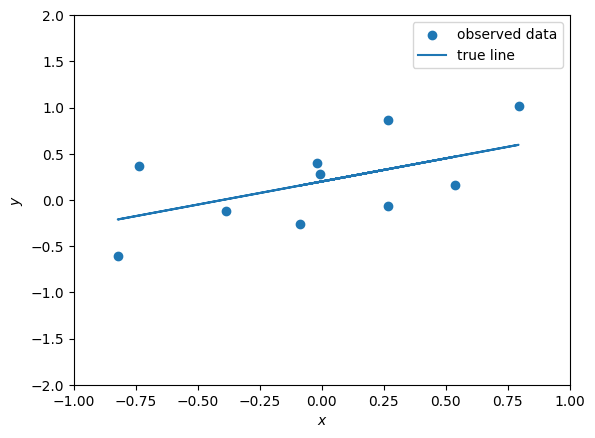

In [12]:
t.manual_seed(0)

N = 10  # number of datapoints
x = 2*t.rand(N) - 1
ytrue = 0.2 + 0.5*x
y = ytrue + 0.5*t.randn(N)


plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-1, 1)
plt.ylim(-2, 2)
plt.scatter(x, y, label="observed data")
plt.plot(x, ytrue, label="true line")
plt.legend()
plt.show()

Now, we use linear regression to fit these data, with functions of varying complexity.




In [13]:
W_true = t.tensor([0.2, 0.5])

def fit_W(X, y):
    return t.inverse(X.T @ X) @ (X.T @ y)

def plot(order):
    X     = cheb(x, order)
    W_est = fit_W(X, y)
    print(f"W_true = {W_true.T}")
    print(f"W_est = {W_est.T}")

    plt.figure()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(-1, 1)
    plt.ylim(-2, 2)
    plt.scatter(x, y, label="data");

    x_linspace = t.linspace(-1, 1, 1000)
    plt.plot(x_linspace, cheb(x_linspace, order)@W_est, 'r', label="fitted")
    plt.legend()
    plt.show()

interact_manual(plot, order=IntSlider(min=0, max=10));

interactive(children=(IntSlider(value=0, description='order', max=10), Button(description='Run Interact', styl…

There is serious overfitting when we use complicated functions.  So could we just use a simpler function class? Yes, absolutely!

But our current proceedure of just looking at the data and choosing a good-looking function class has problems:
* It is subjective: often different function classes will look pretty good. Which one should we choose?  Should we just guess?
* We often won't be able to easily look at the data.  For instance, if there are multiple input features, or we have to choose the function class for _loads_ of different regressions.

So we need an automated proceedure for choosing the function class.  And that's given to us by cross-validation!

## Cross-validation

How can we measure overfitting?  Cross-validation!

In cross-validation, we split the data into "training" and "validation" sets.  We train the model on the training set, then look at the error/loss on the validation set.



In [14]:
x_train = x[:7]
x_test = x[7:]

y_train = y[:7]
y_test = y[7:]

def plot(order):
    X_train = cheb(x_train, order)
    X_test = cheb(x_test, order)

    W_est = fit_W(X_train, y_train)

    y_est_test = X_test @ W_est
    cross_validation_error = ((y_test - y_est_test)**2).mean()
    print(f"cross validation error: {cross_validation_error}")

    plt.figure()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(-1, 1)
    plt.ylim(-2, 2)
    plt.scatter(x_train, y_train, label="training data");
    plt.scatter(x_test, y_test, label="validation data");
    plt.vlines(x_test, y_test, y_est_test, label="test residuals")


    x_linspace = t.linspace(-1, 1, 1000)
    plt.plot(x_linspace, cheb(x_linspace, order)@W_est, 'r', label="fitted")
    plt.legend()
    plt.show()

interact_manual(plot, order=IntSlider(min=0, max=10));

interactive(children=(IntSlider(value=0, description='order', max=10), Button(description='Run Interact', styl…

We compute the cross-validation error/loss for all the different models, and choose the model with the lowest cross-validation error/loss.

It turns out that we have the lowest cross-validation error for the linear model.  And that's correct, as we generated the data from a linear model!

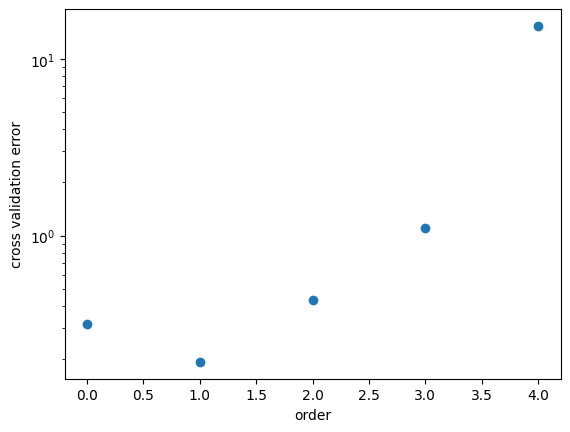

In [15]:
orders = t.arange(5)
cross_validation_errors = []
for order in orders:
    X_train = cheb(x_train, order)
    X_test = cheb(x_test, order)

    W_est = fit_W(X_train, y_train)

    y_est_test = X_test @ W_est
    cross_validation_errors.append(((y_test - y_est_test)**2).mean())

plt.figure()
plt.xlabel("order")
plt.yscale("log")
plt.ylabel("cross validation error")
plt.scatter(orders, cross_validation_errors)
plt.show()

Here, we've used the simplest possible cross-validation scheme, of just "holding out" three datapoints out of the 10.  There are _loads_ more complex schemes.  But they aren't commonly used in AI, so we're not going to delve into them here.

## Regularisation

Using simple functions is great, if the patterns in the data really are simple.
But if the patterns in the data really are complex (but you still have lots of noise) then you've got problems.  You can't just use a simple function, because then you'll underfit (i.e. fail to fit complex patterns in the real data).  But you can't use a complex function, because you'll overfit (i.e. be misled by noise).  

What's the solution?  Regularisation.  Regularisation allows us to use more complex basis functions, but stops the function from going crazy by penalising large values for the weights.

Specifically, the loss function for regularised linear regression is slightly modified,
\begin{align}
\mathcal{L} &= \sum_i (\hat{y}(x_i) - y_i)^2 + \lambda \sum_j w_j^2.
\end{align}
We keep the squared error term, and we add a term that penalises very large values for the weights.

That results in a slightly modified equation for the optimal weights,
\begin{align}
  \mathbf{w} &= (\mathbf{X}^T \mathbf{X} + \lambda I)^{-1} \mathbf{X}^T \mathbf{y}.
\end{align}
Note that this is very similar to the usual expression, but we have added $+ \lambda I$ inside the matrix inverse.

And we consider a slightly modified datasets, with complex underlying patterns,

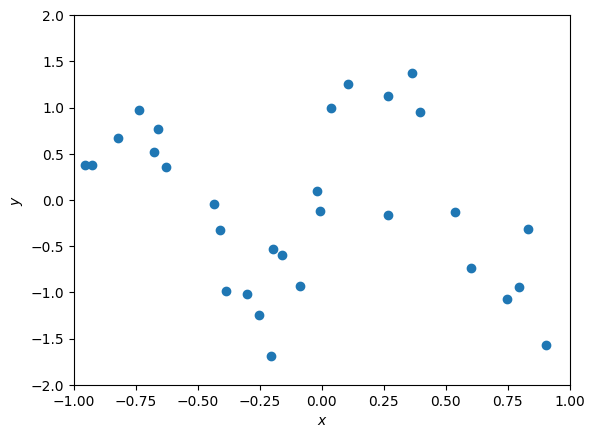

In [8]:
t.manual_seed(0)

N     = 30  # number of datapoints
W_true = t.tensor([0, 0, 0, 0, 0, 0.3])

x     = 2*t.rand(N) - 1
y     = t.sin(6*x) + 0.5*t.randn(N)

plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(x, y)

In [16]:
x_train = x[:10]
x_test = x[10:]

y_train = y[:10]
y_test = y[10:]

def fit_W_reg(X, y, reg):
    return t.inverse(X.mT @ X + reg*t.eye(X.shape[-1])) @ (X.mT @ y)

def plot(order, reg):
    X_train = cheb(x_train, order)
    X_test  = cheb(x_test, order)

    W_est    = fit_W_reg(X_train, y_train, reg)

    y_test_est = X_test @ W_est
    cross_validation_error = ((y_test - y_test_est)**2).mean()
    print(f"cross validation error: {cross_validation_error}")
    print(f"W_est: {W_est}")

    plt.figure()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(-1, 1)
    plt.ylim(-2, 2)
    plt.scatter(x_train, y_train, label="training data");
    plt.scatter(x_test, y_test, label="validation data");
    plt.vlines(x_test, y_test, y_test_est, label="test residuals")


    x_linspace = t.linspace(-1, 1, 1000)
    plt.plot(x_linspace, cheb(x_linspace, order)@W_est, 'r', label="fitted")
    plt.legend()
    plt.show()

interact_manual(plot, order=IntSlider(min=0, max=9), reg=FloatSlider(min=0, max=2));

interactive(children=(IntSlider(value=0, description='order', max=9), FloatSlider(value=0.0, description='reg'…

Note that in this example, the corollary of overfitting is the estimated weights getting really big.

Regularisation explicitly penalises large weights, and gives more sensible solutions.

<h3> Automatic selection of the regulariser using cross-validation </h3>

Now things are even worse.  Before, we just had to choose the "function complexity", which was a smallish integer.  Now we have to choose a regulariser, and we don't even know what type of size the regulariser should be.

The only thing we can do is to use cross-validation!

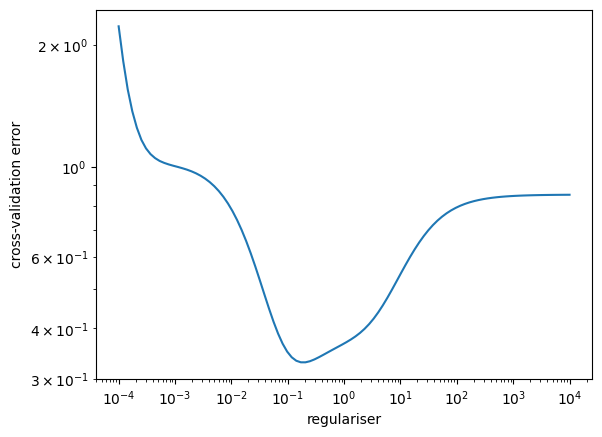

In [10]:
log_10_regs = np.linspace(-4, 4, 100)
regs = 10**log_10_regs
cross_validation_errors = []
for reg in regs:
    X_train = cheb(x_train, order=9)
    X_test  = cheb(x_test, order=9)

    W_est    = fit_W_reg(X_train, y_train, reg)

    y_test_est = X_test @ W_est
    cross_validation_errors.append(((y_test - y_test_est)**2).mean().item())


plt.figure()
plt.xlabel("regulariser")
plt.ylabel("cross-validation error")
plt.xscale('log')
plt.yscale('log')
plt.plot(regs, cross_validation_errors);

Now we can select the regulariser with the lowest cross-validation error.

cross validation error: 0.32968416810035706
W_est: tensor([-0.1457, -0.2924,  0.0578, -0.0420, -0.0482,  0.7165,  0.1260, -0.1945,
         0.2772,  0.0643])


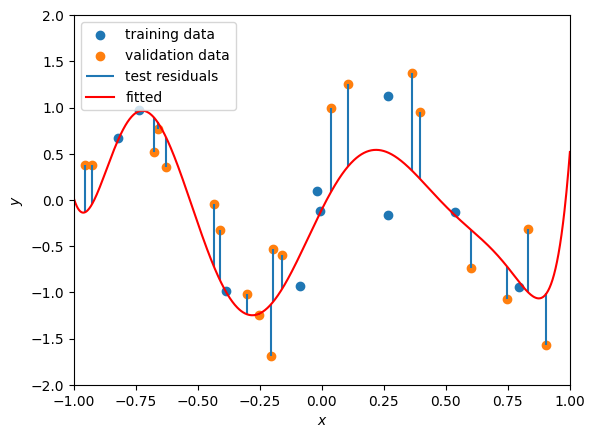

In [11]:
best_reg = regs[t.argmin(t.tensor(cross_validation_errors))]
plot(order=9, reg=best_reg)

<h3> Limits of cross-validation </h3>

There's a bunch of issues with cross-validation:
<ul>
    <li> Parameter sweeps can be numerically costly. </li>
    <li> Splitting your data gives you less data for training, which is very problematic with smaller amounts of data. </li>
    <li> Scales poorly if you want to cross-validate many different parameters. </li>
</ul>